In [15]:
!pip install gym-super-mario-bros==7.4.0
# !pip install tensordict==0.3.0
# !pip install torchrl==0.3.0

In [16]:
# !pip install torchvision
!pip install matplotlib tensorflow-macos tensorflow-metal

In [17]:
# import torch
# from torch import nn
# from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os

# Gym is an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
import gym_super_mario_bros

# from tensordict import TensorDict
# from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models

In [18]:
# Initialize Super Mario environment (in v0.26 change render mode to 'human' to see results on the screen)
# if gym.__version__ < '0.26':
#     env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", new_step_api=True)
# else:
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode='rgb', apply_api_compatibility=True)

# Limit the action-space to
#   0. walk right
#   1. jump right
env = JoypadSpace(env, [["right"], ["right", "A"]])

env.reset()
next_state, reward, done, trunc, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

(240, 256, 3),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


/Users/marinus/miniconda3/envs/mario/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/Users/marinus/miniconda3/envs/mario/lib/python3.8/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


In [19]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info


# class GrayScaleObservation(gym.ObservationWrapper):
#     def __init__(self, env):
#         super().__init__(env)
#         obs_shape = self.observation_space.shape[:2]
#         self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

#     def permute_orientation(self, observation):
#         # permute [H, W, C] array to [C, H, W] tensor
#         observation = np.transpose(observation, (2, 0, 1))
#         observation = torch.tensor(observation.copy(), dtype=torch.float)
#         return observation

#     def observation(self, observation):
#         observation = self.permute_orientation(observation)
#         transform = T.Grayscale()
#         observation = transform(observation)
#         return observation


# class ResizeObservation(gym.ObservationWrapper):
#     def __init__(self, env, shape):
#         super().__init__(env)
#         if isinstance(shape, int):
#             self.shape = (shape, shape)
#         else:
#             self.shape = tuple(shape)

#         obs_shape = self.shape + self.observation_space.shape[2:]
#         self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

#     def observation(self, observation):
#         transforms = T.Compose(
#             [T.Resize(self.shape, antialias=True), T.Normalize(0, 255)]
#         )
#         observation = transforms(observation).squeeze(0)
#         return observation

class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]  # Assuming grayscale reduces the channel to 1
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # TensorFlow processes images in [H, W, C] format, so no need to permute
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        observation = tf.image.rgb_to_grayscale(observation)
        observation = tf.cast(observation, tf.uint8)  # Ensure the data type matches the observation space
        return observation.numpy().squeeze(-1)  # Squeeze to remove the last dimension

class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        # Adjust observation space to match the new shape, keeping the channel dimension as is
        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        # Ensure observation has at least 3 dimensions [height, width, channels]
        if len(observation.shape) == 2:  # Grayscale image, missing channels dimension
            observation = np.expand_dims(observation, axis=-1)  # Add channels dimension

        observation = np.expand_dims(observation, axis=0)  # Add batch dimension for single observation

        observation = tf.convert_to_tensor(observation, dtype=tf.float32)
        observation = tf.image.resize(observation, self.shape, method='area')
        observation = tf.cast(observation, tf.uint8)  # Ensure the data type matches the observation space

        # Remove batch dimension before returning
        observation = tf.squeeze(observation, axis=0)
        return observation.numpy()



# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
from packaging import version

if version.parse(gym.__version__) < version.parse('0.26'):
    env = FrameStack(env, num_stack=4, new_step_api=True)
else:
    env = FrameStack(env, num_stack=4)


In [20]:
# class MarioNet(nn.Module):
#     """mini CNN structure
#   input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
#   """

#     def __init__(self, input_dim, output_dim):
#         super().__init__()
#         c, h, w = input_dim

#         if h != 84:
#             raise ValueError(f"Expecting input height: 84, got: {h}")
#         if w != 84:
#             raise ValueError(f"Expecting input width: 84, got: {w}")

#         self.online = self.__build_cnn(c, output_dim)

#         self.target = self.__build_cnn(c, output_dim)
#         self.target.load_state_dict(self.online.state_dict())

#         # Q_target parameters are frozen.
#         for p in self.target.parameters():
#             p.requires_grad = False

#     def forward(self, input, model):
#         if model == "online":
#             return self.online(input)
#         elif model == "target":
#             return self.target(input)

#     def __build_cnn(self, c, output_dim):
#         return nn.Sequential(
#             nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(3136, 512),
#             nn.ReLU(),
#             nn.Linear(512, output_dim),
#         )

class MarioNet(tf.keras.Model):
    """mini CNN structure
    input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
    """

    def __init__(self, input_dim, output_dim):
        super(MarioNet, self).__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = self.__build_cnn(c, output_dim)
        self.target = self.__build_cnn(c, output_dim)
        self.target.set_weights(self.online.get_weights())

        # Freeze Q_target parameters.
        self.target.trainable = False

    def call(self, inputs, training=None, model="online"):
        if model == "online":
            return self.online(inputs)
        elif model == "target":
            return self.target(inputs)

    def __build_cnn(self, c, output_dim):
        model = models.Sequential([
            layers.Conv2D(filters=32, kernel_size=8, strides=4, activation='relu', input_shape=(c, 84, 84, 1)),
            layers.Conv2D(filters=64, kernel_size=4, strides=2, activation='relu'),
            layers.Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'),
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dense(output_dim)
        ])
        return model


In [21]:
class Mario:
    def __init__(self, state_dim, action_dim, save_dir):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        # self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Mario's DNN to predict the most optimal action - we implement this in the Learn section
        # self.net = MarioNet(self.state_dim, self.action_dim).float()
        # self.net = self.net.to(device=self.device)
        self.net = MarioNet(self.state_dim, self.action_dim)
        self.net.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00025), loss='mean_squared_error')

        self.exploration_rate = 0.8
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.save_every = 50_000  # no. of experiences between saving Mario Net

    def act(self, state):
        """
    Given a state, choose an epsilon-greedy action and update value of step.

    Inputs:
    state(``LazyFrame``): A single observation of the current state, dimension is (state_dim)
    Outputs:
    ``action_idx`` (``int``): An integer representing which action Mario will perform
    """
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # EXPLOIT
        # else:
        #     state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
        #     state = torch.tensor(state, device=self.device).unsqueeze(0)
        #     action_values = self.net(state, model="online")
        #     action_idx = torch.argmax(action_values, axis=1).item()

        # EXPLOIT
        else:
            state = np.array(state[0]) if isinstance(state, tuple) else np.array(state)
            state = tf.convert_to_tensor(state, dtype=tf.float32)
            state = tf.expand_dims(state, axis=0)  # Equivalent to unsqueeze in PyTorch
            action_values = self.net(state, training=False)  # Predict with the online model
            action_idx = tf.argmax(action_values, axis=1).numpy().item()
        # EXPLOIT
        # else:
        #     # Assuming 'state' is a LazyFrames object or similar, first convert to numpy array
        #     state = np.array(state[0]) if isinstance(state, tuple) else np.array(state)
            
        #     # Convert state to float32 and normalize
        #     state = state.astype(np.float32) / 255.0
            
        #     # Ensure state has the shape (84, 84, 4) which is required by the model
        #     # If the last dimension is 1 (grayscale images), we assume the state needs to be reshaped
        #     if state.shape[-1] == 1:
        #         # Remove the last dimension since it's unnecessary
        #         state = np.squeeze(state, axis=-1)
            
        #     # Reshape the state to have the shape (1, 84, 84, 4) for the model
        #     # This includes adding a batch dimension and ensuring the channel dimension is correct
        #     state = np.transpose(state, (1, 2, 0))  # Transpose to (84, 84, 4)
        #     state = np.expand_dims(state, axis=0)  # Add batch dimension to make it (1, 84, 84, 4)
            
        #     # Convert to a TensorFlow tensor
        #     state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
            
        #     # Predict with the online model
        #     action_values = self.net(state_tensor, training=False)
            
        #     # Determine the action
        #     action_idx = tf.argmax(action_values, axis=1).numpy().item()



        # decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # increment step
        self.curr_step += 1
        return action_idx

In [22]:
# class Mario(Mario):  # subclassing for continuity
#     def __init__(self, state_dim, action_dim, save_dir):
#         super().__init__(state_dim, action_dim, save_dir)
#         self.memory = TensorDictReplayBuffer(storage=LazyMemmapStorage(100000, device=torch.device("cpu")))
#         self.batch_size = 32

#     def cache(self, state, next_state, action, reward, done):
#         """
#         Store the experience to self.memory (replay buffer)

#         Inputs:
#         state (``LazyFrame``),
#         next_state (``LazyFrame``),
#         action (``int``),
#         reward (``float``),
#         done(``bool``))
#         """
#         def first_if_tuple(x):
#             return x[0] if isinstance(x, tuple) else x
#         state = first_if_tuple(state).__array__()
#         next_state = first_if_tuple(next_state).__array__()

#         state = torch.tensor(state)
#         next_state = torch.tensor(next_state)
#         action = torch.tensor([action])
#         reward = torch.tensor([reward])
#         done = torch.tensor([done])

#         # self.memory.append((state, next_state, action, reward, done,))
#         self.memory.add(TensorDict({"state": state, "next_state": next_state, "action": action, "reward": reward, "done": done}, batch_size=[]))

#     def recall(self):
#         """
#         Retrieve a batch of experiences from memory
#         """
#         batch = self.memory.sample(self.batch_size).to(self.device)
#         state, next_state, action, reward, done = (batch.get(key) for key in ("state", "next_state", "action", "reward", "done"))
#         return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

from collections import deque

class Mario(Mario):  # Assuming 'Mario' is properly defined elsewhere for TensorFlow
    def __init__(self, state_dim, action_dim, save_dir, buffer_size=100000):
        super().__init__(state_dim, action_dim, save_dir)
        self.memory = deque(maxlen=buffer_size)  # Replay buffer using deque
        self.batch_size = 32

    def cache(self, state, next_state, action, reward, done):
        """
        Store the experience to self.memory (replay buffer)

        Inputs:
        state, next_state (could be `LazyFrame` or any supported format),
        action (int),
        reward (float),
        done (bool)
        """
        def first_if_tuple(x):
            return x[0] if isinstance(x, tuple) else x
        
        state = np.array(first_if_tuple(state))
        next_state = np.array(first_if_tuple(next_state))

        # No need to convert to TensorFlow tensors here, as we'll do it in batch during recall
        self.memory.append((state, next_state, action, reward, done))

    def recall(self):
        """
        Retrieve a batch of experiences from memory
        """
        batch = np.random.choice(len(self.memory), size=self.batch_size, replace=False)
        states, next_states, actions, rewards, dones = zip(*[self.memory[idx] for idx in batch])

        # Convert batched data to TensorFlow tensors
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.int32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)

        return states, next_states, actions, rewards, dones


In [23]:
# class Mario(Mario):
#     def __init__(self, state_dim, action_dim, save_dir):
#         super().__init__(state_dim, action_dim, save_dir)
#         self.gamma = 0.9

#     def td_estimate(self, state, action):
#         current_Q = self.net(state, model="online")[
#             np.arange(0, self.batch_size), action
#         ]  # Q_online(s,a)
#         return current_Q

#     @torch.no_grad()
#     def td_target(self, reward, next_state, done):
#         next_state_Q = self.net(next_state, model="online")
#         best_action = torch.argmax(next_state_Q, axis=1)
#         next_Q = self.net(next_state, model="target")[
#             np.arange(0, self.batch_size), best_action
#         ]
#         return (reward + (1 - done.float()) * self.gamma * next_Q).float()
import tensorflow as tf

class Mario(Mario):  # Assuming 'Mario' is the base class properly defined for TensorFlow
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.gamma = 0.9

    def td_estimate(self, state, action):
        current_Q = self.net(state, training=False)  # Get Q values for all actions
        batch_indices = tf.range(0, self.batch_size, dtype=tf.int32)  # Ensure dtype matches action's dtype
        action_indices = tf.stack([batch_indices, action], axis=1)
        current_Q = tf.gather_nd(current_Q, action_indices)  # Extract Q value for the taken action
        return current_Q

    def td_target(self, reward, next_state, done):
        next_state_Q_online = self.net(next_state, training=False)  # Predicted Q values from the online network
        best_action = tf.argmax(next_state_Q_online, axis=1, output_type=tf.int32)  # Explicitly set output type
        
        next_state_Q_target = self.net(next_state, training=False, model="target")  # Predicted Q values from the target network
        batch_indices = tf.range(0, self.batch_size, dtype=tf.int32)  # Ensure dtype matches best_action's dtype
        best_action_indices = tf.stack([batch_indices, best_action], axis=1)
        next_Q = tf.gather_nd(next_state_Q_target, best_action_indices)
        
        not_done = 1 - tf.cast(done, tf.float32)
        td_target = reward + not_done * self.gamma * next_Q
        return td_target



In [24]:
# class Mario(Mario):
#     def __init__(self, state_dim, action_dim, save_dir):
#         super().__init__(state_dim, action_dim, save_dir)
#         self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
#         self.loss_fn = torch.nn.SmoothL1Loss()

#     def update_Q_online(self, td_estimate, td_target):
#         loss = self.loss_fn(td_estimate, td_target)
#         self.optimizer.zero_grad()
#         loss.backward()
#         self.optimizer.step()
#         return loss.item()

#     def sync_Q_target(self):
#         self.net.target.load_state_dict(self.net.online.state_dict())
import tensorflow as tf

class Mario(Mario):  # Assuming 'Mario' is the base class properly defined for TensorFlow
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        # Initialize the optimizer
        self.optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00025)
        # Initialize the loss function
        self.loss_fn = tf.keras.losses.Huber()

    def update_Q_online(self, state_batch, action_batch, td_target):
        with tf.GradientTape() as tape:
            state_action_values = tf.reduce_sum(
                self.net(state_batch, training=True) * tf.one_hot(action_batch, self.action_dim), axis=1)
            loss = self.loss_fn(td_target, state_action_values)
        gradients = tape.gradient(loss, self.net.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.net.trainable_variables))
        return loss.numpy()

    def sync_Q_target(self):
        self.net.target.set_weights(self.net.online.get_weights())


In [25]:
# class Mario(Mario):
#     def save(self):
#         save_path = (self.save_dir / f"mario_net_{self.curr_step}.chkpt")
#         torch.save(dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate), save_path)
#         print(f"MarioNet saved to {save_path} at step {self.curr_step}")
    
#     def load(self, file_name=None):
#         checkpoint = torch.load(file_name)
#         self.net.load_state_dict(checkpoint['model'])
#         # self.exploration_rate = checkpoint['exploration_rate']
#         print(f"Loaded MarioNet from {file_name}")
import tensorflow as tf
import json

class Mario(Mario):  # Assuming 'Mario' is the base class properly defined for TensorFlow
    def save(self):
        save_path = str(self.save_dir / f"mario_net_{self.curr_step}")
        self.net.save(save_path + ".tf")  # Save the TensorFlow model
        # Save exploration rate in a separate JSON file for simplicity
        with open(save_path + "_exploration_rate.json", 'w') as f:
            json.dump({"exploration_rate": self.exploration_rate}, f)
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")
    
    def load(self, file_name=None):
        # Load the TensorFlow model
        self.net = tf.keras.models.load_model(file_name + ".tf")
        # Load exploration rate from a separate JSON file
        with open(file_name + "_exploration_rate.json", 'r') as f:
            exploration_rate_data = json.load(f)
            self.exploration_rate = exploration_rate_data['exploration_rate']
        print(f"Loaded MarioNet from {file_name}")


In [26]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.burnin = 1e4  # min. experiences before training
        self.learn_every = 3  # no. of experiences between updates to Q_online
        self.sync_every = 10_000  # no. of experiences between Q_target & Q_online sync

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        state, next_state, action, reward, done = self.recall()

        td_target = self.td_target(reward, next_state, done)
        loss = self.update_Q_online(state, action, td_target)

        return td_target.numpy().mean(), loss

In [27]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {round(epsilon,4)} - "
            f"Mean Reward {round(mean_ep_reward,0)} - "
            f"Mean Length {round(mean_ep_length, 0)} - "
            f"Mean Loss {round(mean_ep_loss, 0)} - "
            f"Mean Q Value {round(mean_ep_q, 0)} - "
            f"Time Delta {round(time_since_last_record, 2)} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_lengths", "ep_avg_losses", "ep_avg_qs", "ep_rewards"]:
            plt.clf()
            plt.plot(getattr(self, f"moving_avg_{metric}"), label=f"moving_avg_{metric}")
            plt.legend()
            plt.savefig(getattr(self, f"{metric}_plot"))

actions:  2
Episode 0 - Step 2005 - Epsilon 0.4979 - Mean Reward 267.0 - Mean Length 2005.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 15.51 - Time 2024-02-21T16:43:51
Episode 10 - Step 7608 - Epsilon 0.4922 - Mean Reward 409.0 - Mean Length 692.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 43.34 - Time 2024-02-21T16:44:34


INFO:tensorflow:Assets written to: checkpoints/2024-02-21T16-43-35/mario_net_10000.tf/assets


INFO:tensorflow:Assets written to: checkpoints/2024-02-21T16-43-35/mario_net_10000.tf/assets


MarioNet saved to checkpoints/2024-02-21T16-43-35/mario_net_10000 at step 10000
Episode 20 - Step 10781 - Epsilon 0.4889 - Mean Reward 477.0 - Mean Length 513.0 - Mean Loss 1.0 - Mean Q Value 0.0 - Time Delta 242.75 - Time 2024-02-21T16:48:37


KeyboardInterrupt: 

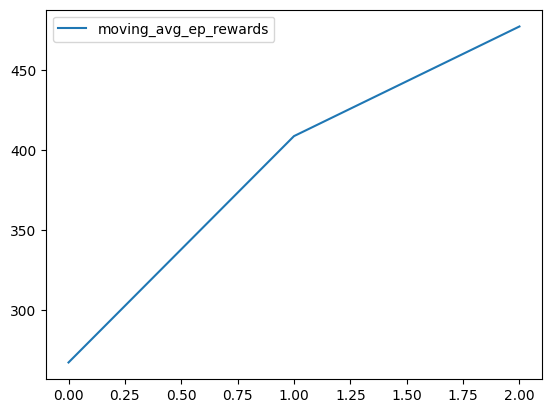

In [28]:
# use_cuda = torch.cuda.is_available()
# print(f"Using CUDA: {use_cuda}")
# print()
tf.config.set_visible_devices([], 'GPU')
save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)
print("actions: ", env.action_space.n)
# mario.load("checkpoints/trained_mario.chkpt")
# mario.load("checkpoints/2024-02-20T23-02-38/mario_net_60.chkpt")

mario.exploration_rate = 0.5
mario.exploration_rate_decay = 0.9999979205606203 #0.99999975
mario.exploration_rate_min = 0.1
mario.save_every = 10_000  # no. of experiences between saving Mario Net

logger = MetricLogger(save_dir)

episodes = 4000
for e in range(episodes):

    state = env.reset()

    # Play the game!
    while True:

        # Run agent on the state
        action = mario.act(state)
        # print(state)
        # action = 0
        # if action == 0:
        #     action = 1
        # else:
        #     action = 0
        # print(action)
        # Agent performs action
        next_state, reward, done, trunc, info = env.step(action)
        

        # Remember
        mario.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = mario.learn()

        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        # Check if end of game
        if done or info["flag_get"]:
            break

    logger.log_episode()

    if (e % 10 == 0) or (e == episodes - 1):
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)